In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
mesh_width = 5  # количество ячеек по пространству
mesh_height = 1000  # количество ячеек по времени

In [3]:
dt = 10  # сут, временной шаг
dt *= 24 * 60 * 60  # с, временной шаг

m = 0.15  # пористость

mu = 5  # мПа*с, вязкость жидкости
mu *= 1e-3  # Па*с, вязкость жидкости

k = 5  # мД, проницаемость
k *= 1e-3 * (1e-6) ** 2  # м^2, проницаемость

dx = 100  # м, длина ячейки

compr = 2.4e-9  # Па^(-1), общая сжимаемость

a_square = 10000  # м^2, площадь поверхности боковой грани ячейки

p_initial = 24  # МПа, начальное давление в ячейках
p_initial *= 1e6  # Па, начальное давление в ячейках

q_right = 9  # м^3/сут, расход на правой границе
q_right /= (24 * 60 * 60)  # м^3/с, расход на правой границе

p_left = 20  # МПа, давление на левой границе
p_left *= 1e6  # Па, давление на левой границе

In [4]:
# безразмерный параметр, входящий в формулы неявного метода
gamma = (m * mu * compr / k) * (dx ** 2 / dt)
gamma

4.166666666666666

In [5]:
# задание матрицы для значений давления по координате и времени
p_implicit = np.zeros([mesh_height, mesh_width])
# задание начальных условий в узлах
p_implicit[0][:] = p_initial
p_implicit

array([[24000000., 24000000., 24000000., 24000000., 24000000.],
       [       0.,        0.,        0.,        0.,        0.],
       [       0.,        0.,        0.,        0.,        0.],
       ...,
       [       0.,        0.,        0.,        0.,        0.],
       [       0.,        0.,        0.,        0.,        0.],
       [       0.,        0.,        0.,        0.,        0.]])

In [6]:
# решение неявным методом
for t_ind in range(1, mesh_height):
    alpha = np.zeros(mesh_width)  # массив для прогоночных коэффициентов alpha
    beta = np.zeros(mesh_width)  # массив для прогоночных коэффициентов beta
    
    # прямой ход прогонки
    for x_ind in range(0, mesh_width):
        if x_ind == 0:
            a = 0
            b = -3 - 0.75 * gamma
            c = 1
            d = -0.75 * gamma * p_implicit[t_ind - 1][x_ind] - 2 * p_left
        elif x_ind == mesh_width - 1:
            a = 1
            b = -1 - gamma
            c = 0
            d = -q_right * dx * mu / (a_square * k) - gamma * p_implicit[t_ind - 1][x_ind]
        else:
            a = 1
            b = -2 - gamma
            c = 1
            d = -gamma * p_implicit[t_ind - 1][x_ind]
        
        if x_ind == 0:
            alpha[x_ind] = - c / b
            beta[x_ind] = d / b
        else:
            alpha[x_ind] = - c / (a * alpha[x_ind - 1] + b)
            beta[x_ind] = (d - a * beta[x_ind - 1]) / (a * alpha[x_ind - 1] + b)
    
    # обратный ход прогонки
    for x_ind in range(mesh_width - 1, -1, -1):
        if x_ind == mesh_width - 1:
            p_implicit[t_ind][x_ind] = beta[x_ind]
        else:
            p_implicit[t_ind][x_ind] = alpha[x_ind] * p_implicit[t_ind][x_ind + 1] + beta[x_ind]

In [7]:
# перевод значений давления из Па в МПа
p_implicit /= 1e6
print('Далее выведены значения давлений в нулевой, первый и второй моменты времени,'
      '\nа также значения давлений (последние 3 строки) на установившемся режиме:')
p_implicit

Далее выведены значения давлений в нулевой, первый и второй моменты времени,
а также значения давлений (последние 3 строки) на установившемся режиме:


array([[24.        , 24.        , 24.        , 24.        , 24.        ],
       [22.65749991, 23.77718692, 23.96848611, 24.02847742, 24.20712466],
       [21.92703319, 23.49839106, 23.90809954, 24.06619731, 24.3814613 ],
       ...,
       [20.52083333, 21.5625    , 22.60416667, 23.64583333, 24.6875    ],
       [20.52083333, 21.5625    , 22.60416667, 23.64583333, 24.6875    ],
       [20.52083333, 21.5625    , 22.60416667, 23.64583333, 24.6875    ]])

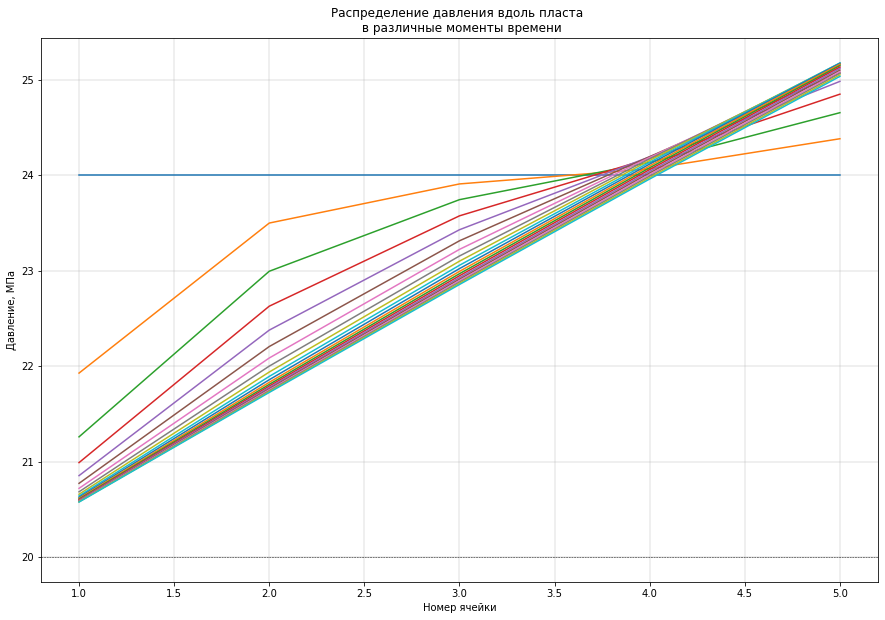

In [8]:
# построение графиков распределения давления по пласту
fig = plt.figure(figsize=(15,10))
for p_distribution in p_implicit[:40:2]:
    plt.plot(range(1, 6), p_distribution)

plt.title('Распределение давления вдоль пласта \n в различные моменты времени')
plt.xlabel('Номер ячейки')
plt.ylabel('Давление, МПа')

plt.axhline(y=20.0, color='black', linestyle='--', linewidth=0.5)
plt.grid(linewidth=0.4)
plt.show()